In [1]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import colormaps
from io import StringIO  
import sys
sys.path.append('../')
from utils.results_utils import BaseSubsamplingType
import torch
import pandas as pd
api = wandb.Api()
from importlib import reload

import subsampling_classes
import plot_funcs
subsampling_classes = reload(subsampling_classes)
plot_funcs = reload(plot_funcs)
from subsampling_classes import *
from plot_funcs import *
import seaborn as sns

In [2]:
is_saving_allowed = True
force_recompute = False

entity = 'haraghi'
folder_name = 'paper'
experiment_folder_name = 'offset'

assert not is_saving_allowed, "Are you sure? Please set is_saving_allowed to False."

AssertionError: Are you sure? Please set is_saving_allowed to False.

In [3]:
subfolder_name = os.path.join('../images/subsampling_methods',folder_name,experiment_folder_name)
if is_saving_allowed:
    if not os.path.exists(subfolder_name):
        os.makedirs(subfolder_name)
    # file_path = os.path.join(subfolder_name,"sparsity_vs_acc.tex")

In [4]:
datasets_name_and_num_classes = {
    "NCARS": {"name": "N-Cars", "num_classes": 2},
    "NASL": {"name": "N-ASL", "num_classes": 24},
    "NCALTECH101": {"name": "N-Caltech101", "num_classes": 101},
    "DVSGESTURE_TONIC": {"name": "DVS-Gesture", "num_classes": 11},}
for key,value in datasets_name_and_num_classes.items():
    print(f"{key}: {value['name']}")

NCARS: N-Cars
NASL: N-ASL
NCALTECH101: N-Caltech101
DVSGESTURE_TONIC: DVS-Gesture


In [5]:
kw = "DVS"
projects = api.projects(entity="haraghi")
for project in projects:
    if kw in project.name:
        print(project.name)

Spatial_DVSGESTURE_TONIC_ZERO_OFFSET
Spatiotemporal_DVSGESTURE_TONIC_remaining
Random_DVSGESTURE_TONIC_remaining
Spatial_DVSGESTURE_TONIC_CORRECTED_OFFSET
TOS_2D_Harris_DVS_GESTURE_TONIC_spatial_upsampled
Baseline_EventCount_DVS_GESTURE_TONIC_spatial_upsampled
Temporal_random_offsets_DVS_GESTURE_TONIC
Temporal_dataset_wide_random_offsets_DVS_GESTURE_TONIC
Spatial_dataset_wide_random_offsets_DVS_GESTURE_TONIC
Spatial_with_random_offsets_DVS_GESTURE_TONIC
Spatial_with_offset_DVS_GESTURE_TONIC
Subsamplimg_methods_DVS_GESTURE_TONIC
Subsamplimg_acc_comparision_DVS_GESTURE_TONIC
Subsamplimg-vs-bandwidth-DVS_GESTURE_TONIC
FINAL-DVSGESTURE_TONIC-HP-sweep-reduced
FINAL-DVSGESTURE_TONIC-HP-varyinig-sparsity
EST-DVSGESTURE-HP-sweep-InMemory
EST-DVSGESTURE-HP-sweep


In [6]:
datasets_name_and_project = {
"DVSGESTURE_TONIC": [
                        "Spatial_with_offset_DVS_GESTURE_TONIC",
                        "Spatial_DVSGESTURE_TONIC_ZERO_OFFSET",
                        "Spatial_DVSGESTURE_TONIC_CORRECTED_OFFSET",
                        "Spatial_with_random_offsets_DVS_GESTURE_TONIC",
                        "Temporal_dataset_wide_random_offsets_DVS_GESTURE_TONIC",
                        "Temporal_random_offsets_DVS_GESTURE_TONIC",
                        "Subsamplimg_methods_DVS_GESTURE_TONIC", #!!!!
                    ],
}

In [7]:
result_dict = {}
for dataset, project_name in datasets_name_and_project.items():
        
    if dataset != "NCALTECH101" and dataset != "NCARS" and dataset != "DVSGESTURE_TONIC": 
        continue
    
    print('*'*50, flush=True)
    print(dataset+":", flush=True)
    print('*'*50, flush=True)
    result_dict[dataset] = [ 
                    Spatial(dataset_name = dataset),
                    Temporal(dataset_name = dataset),
                    SpatialRandom(dataset_name = dataset),
                    SpatialZeroOffset(dataset_name = dataset),
                    Spatial8x10NonZeroOffset(dataset_name = dataset),
                    TemporalRandom(dataset_name = dataset),
                    TemporalZeroOffset(dataset_name = dataset),               
                ]

    for result_class in result_dict[dataset]:
        result_class.label = legend_labels[result_class.get_name()] if result_class.get_name() in legend_labels else result_class.get_name()
        result_class.color = color_dict[result_class.get_name()] if result_class.get_name() in color_dict else result_class.get_color()
        result_class.marker = marker_dict[result_class.get_name()] if result_class.get_name() in marker_dict else result_class.get_marker()
        
    if force_recompute or not os.path.exists(f"{dataset}_results.pt"):
        if isinstance(project_name,list):
            runs = []
            for p in project_name:
                print('-' *50, flush=True)
                print(p, flush=True)
                print('-' *50, flush=True)
                runs.extend(api.runs(f"{entity}/{p}"))
        else:
            print('-' *50, flush=True)
            print(project_name, flush=True)
            print('-' *50, flush=True)
            runs = api.runs(f"{entity}/{project_name}")
        runs = [r for r in runs if r.state == "finished"]
        if len(runs) == 0:
            print(f"No runs found for {project_name}", flush=True)
            continue
        
        for r in runs:
            for result_class in result_dict[dataset]:
                result_class.process_run(r)
        result_to_save = []
        for result_class in result_dict[dataset]:
            result_class.create_data_frames()
            result_to_save.append(result_class.to_dict())     
        torch.save(result_to_save, f"{dataset}_offset_results.pt")
        
    else:
        result_to_save = torch.load(f"{dataset}_offset_results.pt")
        for result_class in result_dict[dataset]:
            found_flag = False
            for result in result_to_save:
                if result_class.get_name() == result["name"]:
                    result_class.df = pd.read_json(StringIO(result["df"]))
                    result_class.df_zipped = pd.read_json(StringIO(result["df_zipped"]))
                    result_class._agg_bandwidth_acc()
                    result_class._agg_zipped_parameters()
                    result_class._check_empty_num_events()
                    result_class._clean_data_frame() 
                    result_class. _assert_non_empty_num_events_in_zipped()
                    print(f"Loaded {result_class.get_name()} from {dataset}_offset_results.pt")
                    found_flag = True
                    break
            assert found_flag, f"Result not found for {result_class.get_name()} in {dataset}_offset_results.pt"    


**************************************************
DVSGESTURE_TONIC:
**************************************************
Loaded spatial_dataset_wide_random_offsets from DVSGESTURE_TONIC_offset_results.pt
Loaded temporal_dataset_wide_random_offset from DVSGESTURE_TONIC_offset_results.pt
Loaded spatial_random_offsets from DVSGESTURE_TONIC_offset_results.pt
Loaded spatial_zero_offsets from DVSGESTURE_TONIC_offset_results.pt
Loaded spatial_8x10_nonzero_offsets from DVSGESTURE_TONIC_offset_results.pt
Loaded temporal_random_offsets from DVSGESTURE_TONIC_offset_results.pt
Loaded temporal_zero_offset from DVSGESTURE_TONIC_offset_results.pt


/tmp/ipykernel_36660/2233664206.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  result_to_save = torch.load(f"{dataset}_offset_results.pt")
/home/hesam/Projects/DGCNN_C

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0: Spatial (dataset wide random offsets) - spatial_dataset_wide_random_offsets
1: Temporal (dataset wide random offsets) - temporal_dataset_wide_random_offset
2: Spatial (fixed random offsets) - spatial_random_offsets
3: Spatial (zero offsets) - spatial_zero_offsets
4: Spatial (8x10 non-zero offsets) - spatial_8x10_nonzero_offsets
5: Temporal (fixed random offsets) - temporal_random_offsets
6: Temporal (zero offset) - temporal_zero_offset


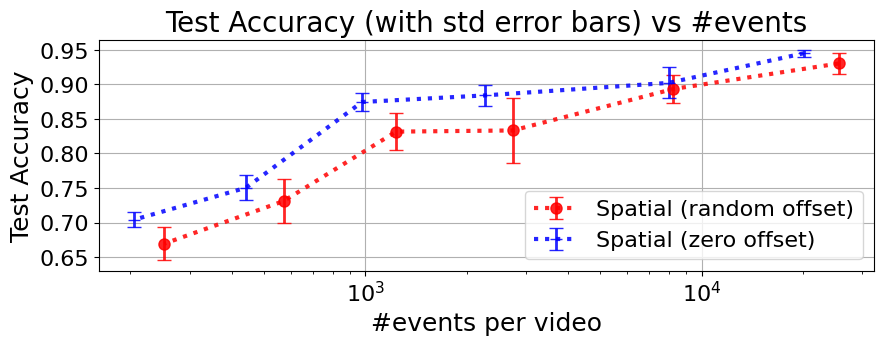

In [15]:
ds_name = "DVSGESTURE_TONIC" 

c_dic = {
                'spatial_zero_offsets': 'blue',
                'spatial_dataset_wide_random_offsets': 'red',
}

l_labels = {
                'spatial_zero_offsets': 'Spatial (zero offset)',
                'spatial_dataset_wide_random_offsets': 'Spatial (random offset)',
}

for ii,r in enumerate(result_dict[ds_name]):
    print(f"{ii}: {r.label} - {r.get_name()}")
if is_saving_allowed:
    save_to_path = os.path.join(subfolder_name,f'spatial_zero_vs_nonzero_{ds_name}.eps')
else:
    save_to_path = None
plot_all([result_dict[ds_name][i] for i in [0,3]],
            save_to=save_to_path,
            color_dict_=c_dic,
            figsize=(10,3),
            label_dict = l_labels,
            x_axis = "num_events",
)

0: Spatial (dataset wide random offsets) - spatial_dataset_wide_random_offsets
1: Temporal (dataset wide random offsets) - temporal_dataset_wide_random_offset
2: Spatial (fixed random offsets) - spatial_random_offsets
3: Spatial (zero offsets) - spatial_zero_offsets
4: Spatial (8x10 non-zero offsets) - spatial_8x10_nonzero_offsets
5: Temporal (fixed random offsets) - temporal_random_offsets
6: Temporal (zero offset) - temporal_zero_offset


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


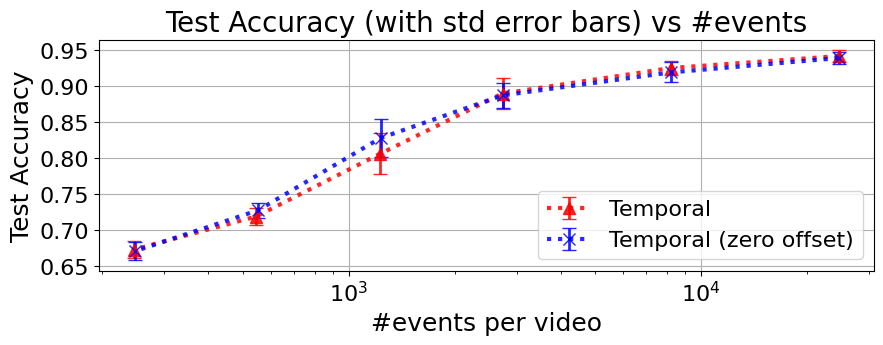

In [16]:
ds_name = "DVSGESTURE_TONIC" 

c_dic = {
                'temporal_zero_offset': 'blue',
                'temporal_dataset_wide_random_offset': 'red',
}

l_labels = {
                'temporal_zero_offset': 'Temporal (zero offset)',
                'temporal_dataset_wide_random_offset': 'Temporal (random offset)',
}

for ii,r in enumerate(result_dict[ds_name]):
    print(f"{ii}: {r.label} - {r.get_name()}")
if is_saving_allowed:
    save_to_path = os.path.join(subfolder_name,f'temporal_zero_vs_nonzero_{ds_name}.eps')
else:
    save_to_path = None
plot_all([result_dict[ds_name][i] for i in [1,6]],
         save_to=save_to_path,
         color_dict_=c_dic,
         figsize=(10,3),
        x_axis = "num_events",

)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


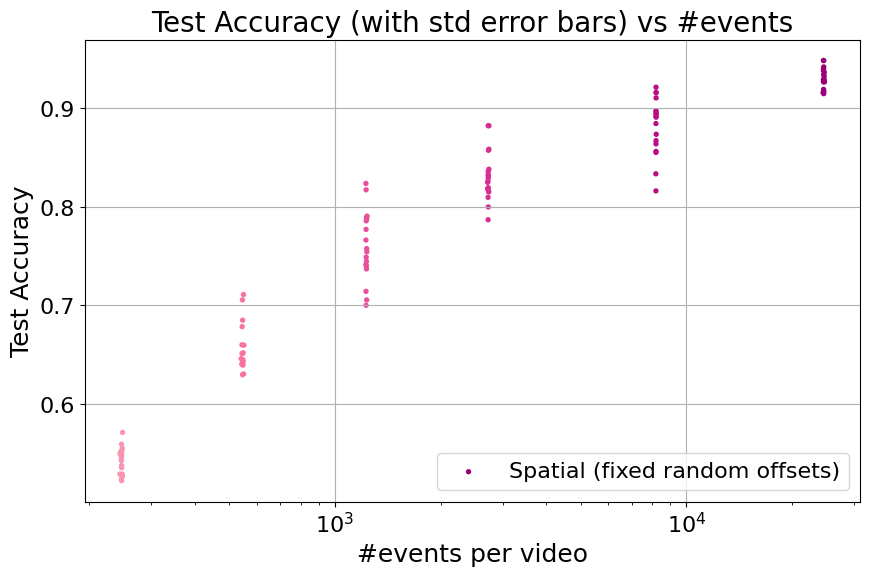

In [10]:
ds_name = "DVSGESTURE_TONIC" 

plot_all(   
            [result_dict[ds_name][i] for i in [2]],
            save_to=save_to_path,
            mean_line = False, 
            scatter_dots = True,
)

In [24]:
result_dict[ds_name][0].df

,seed,h_r,v_r,h_r_offset,v_r_offset,val_acc,test_acc,bandwidth,num_events,h_r_v_r_zipped
0,12,2,2,1,0,0.966480,0.933983,16220.198242,27571.653915,"(2, 2)"
1,12,3,4,1,1,0.914339,0.880952,4959.195312,8427.718121,"(3, 4)"
2,12,6,6,3,1,0.864060,0.766234,1962.205322,3332.515213,"(6, 6)"
3,12,8,10,4,2,0.923650,0.845238,617.830139,1047.212752,"(8, 10)"
4,12,12,15,7,3,0.795158,0.699134,364.589172,615.989485,"(12, 15)"
...,...,...,...,...,...,...,...,...,...,...
103,4200000,3,4,1,2,0.945996,0.883117,4652.149414,7905.844966,"(3, 4)"
104,4200000,6,6,3,4,0.912477,0.832251,1808.588989,3071.479418,"(6, 6)"
105,4200000,8,10,5,6,0.890130,0.822511,810.562195,1374.587919,"(8, 10)"
106,4200000,12,15,7,10,0.800745,0.677489,351.942841,594.285459,"(12, 15)"


In [25]:
pd.options.mode.copy_on_write = True
ds_name = "DVSGESTURE_TONIC" 
for ii,r in enumerate(result_dict[ds_name]):
    print(f"{ii}: {r.label} - {r.get_name()}")
    if r.get_name() == "spatial_8x10_nonzero_offsets":
        valid_offsets = r.df_zipped.dropna()['h_r_offset_v_r_offset_zipped']
        valid_offsets = valid_offsets.drop(valid_offsets[valid_offsets == (3,3)].index)
        all_df = r.df
        filtered_df = all_df[all_df['h_r_offset_v_r_offset_zipped'].isin(valid_offsets)]
    if r.get_name() == "spatial_zero_offsets":
        zero_offset_df_8x10 = r.df[r.df['h_r_v_r_zipped'] == (8,10)]
        zero_offset_df_8x10.loc[:,'h_r_offset_v_r_offset_zipped'] = [(0,0)] * len(zero_offset_df_8x10)
        zero_offset_df_8x10.loc[:,'h_r_offset'] = [0] * len(zero_offset_df_8x10)
        zero_offset_df_8x10.loc[:,'v_r_offset'] = [0] * len(zero_offset_df_8x10)
        
combined_df = pd.concat([filtered_df,zero_offset_df_8x10]).sort_values(by='num_events',ascending=True)
combined_df_bw_grouped_series = combined_df.groupby('h_r_offset_v_r_offset_zipped')
combined_df_bw_grouped = combined_df_bw_grouped_series['num_events'].mean().sort_values(ascending=True).reset_index()

0: Spatial (dataset wide random offsets) - spatial_dataset_wide_random_offsets
1: Temporal (dataset wide random offsets) - temporal_dataset_wide_random_offset
2: Spatial (fixed random offsets) - spatial_random_offsets
3: Spatial (zero offsets) - spatial_zero_offsets
4: Spatial (8x10 non-zero offsets) - spatial_8x10_nonzero_offsets
5: Temporal (fixed random offsets) - temporal_random_offsets
6: Temporal (zero offset) - temporal_zero_offset


/tmp/ipykernel_36660/1253245547.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_36660/1253245547.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


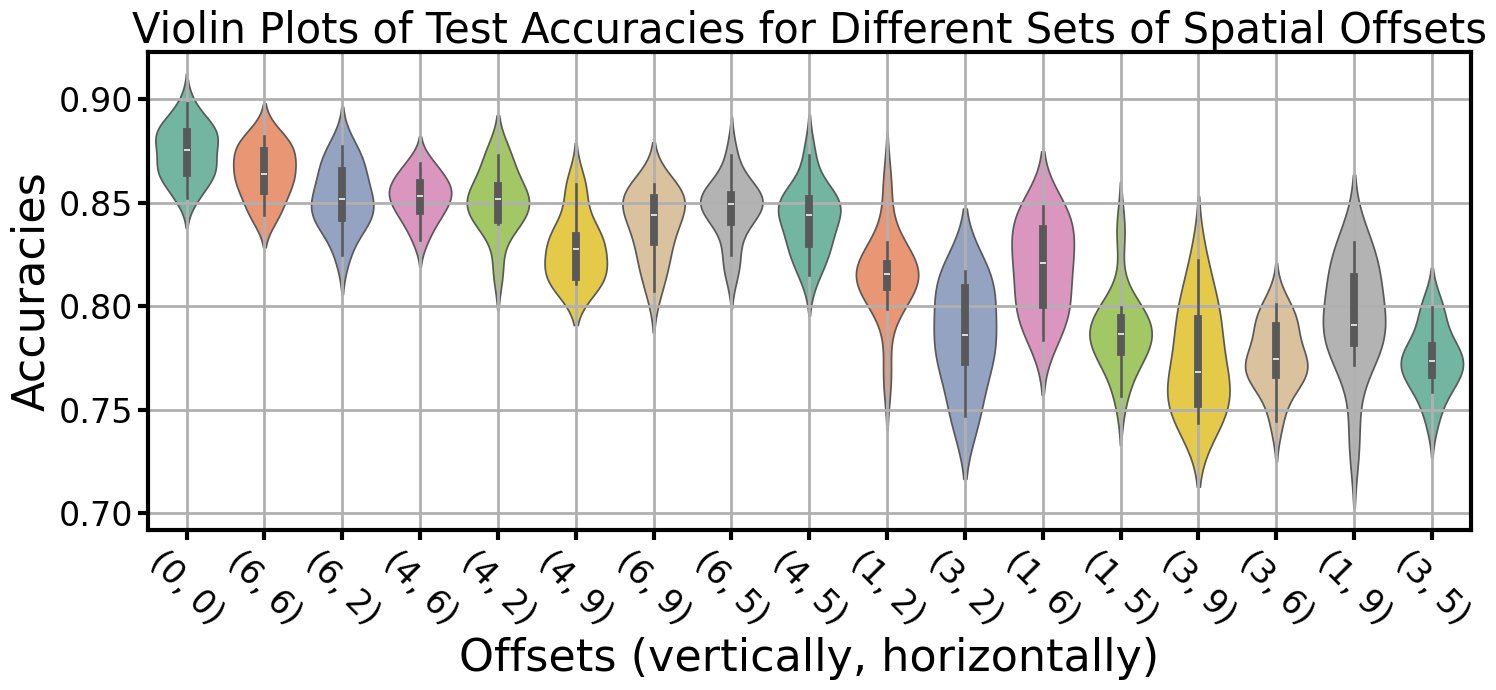

In [28]:
# Initialize the figure
fig, ax1 = plt.subplots(figsize=(15, 7))

# Create the violin plot
sns.violinplot(
        y=combined_df['test_acc'].tolist(), 
        x=combined_df['h_r_offset_v_r_offset_zipped'].map(str).tolist(), 
        inner="box", 
        scale="width", 
        palette="Set2",
        order = combined_df_bw_grouped['h_r_offset_v_r_offset_zipped'].map(str).tolist(),
    )

# Add title and labels
plt.title('Violin Plots of Test Accuracies for Different Sets of Spatial Offsets', fontsize=30) 

# Create the second axis (right side)

ax1.set_xlabel('Offsets (vertically, horizontally)', fontsize=32) 
ax1.set_ylabel('Accuracies', fontsize=32) 
ax1.tick_params(axis='y',  which='both', width=3, length=7, labelsize=24)
ax1.tick_params(axis='x',  which='both', width=3, length=7, labelsize=24, rotation=-45)

# ax2 = ax1.twinx()
# ax2.set_ylabel('#events per video', fontsize=32) 
# # Plot the values and connect them with a line
# ax2.plot(
#     combined_df_bw_grouped.index, 
#     combined_df_bw_grouped['num_events'], 
#     marker='.', 
#     markersize=20,
#     color='k', 
#     linestyle=':', 
#     linewidth=4,
#     alpha=0.7,)
# ax2.tick_params(axis='y',  which='both', width=3, length=7, labelsize=24)

ax1.grid(axis='x' , linewidth=2)  # Adjust as needed
ax1.grid(axis='y', linewidth=2)  # Adjust as needed

for spine in ax1.spines.values():
    spine.set_linewidth(3)  # Adjust thickness as needed

plt.tight_layout()
plt.savefig(os.path.join(subfolder_name,f'violin_plot_spatial_{ds_name}.eps'))
# Show the plot
plt.show()

/tmp/ipykernel_36660/803121047.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_36660/803121047.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


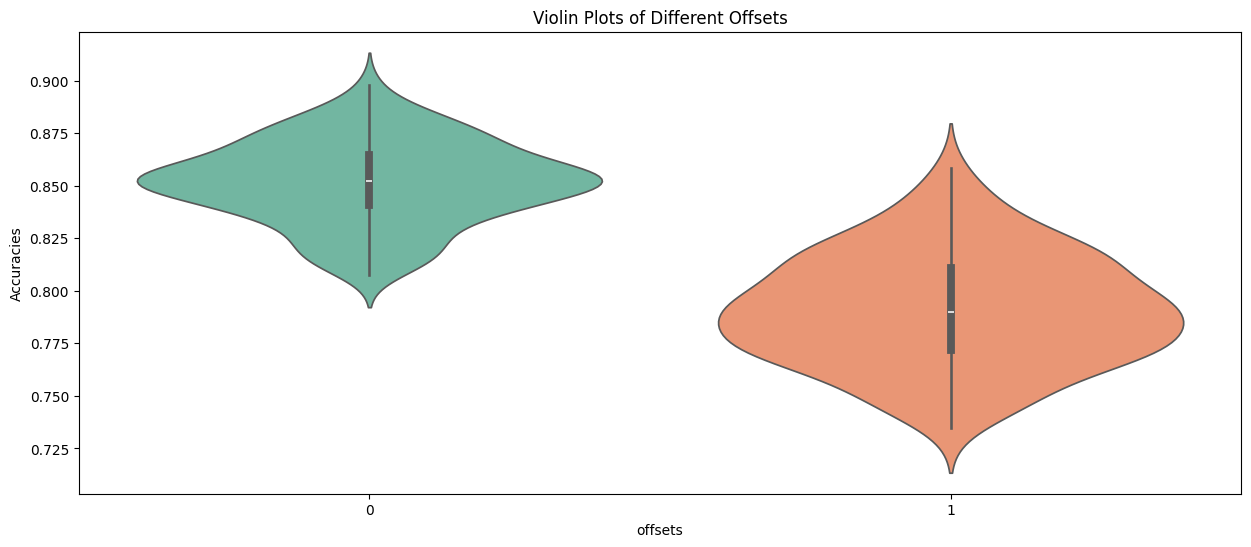

In [13]:
# Initialize the figure
fig, ax1 = plt.subplots(figsize=(15, 6))

# Create the violin plot
sns.violinplot(
        y=combined_df['test_acc'].tolist(), 
        x=(combined_df['h_r_offset']%2).map(str).tolist(), 
        inner="box", 
        scale="width", 
        palette="Set2",
    )

# Add title and labels
plt.title('Violin Plots of Different Offsets')
plt.xlabel('offsets')
plt.ylabel('Accuracies')


# Show the plot
plt.show()

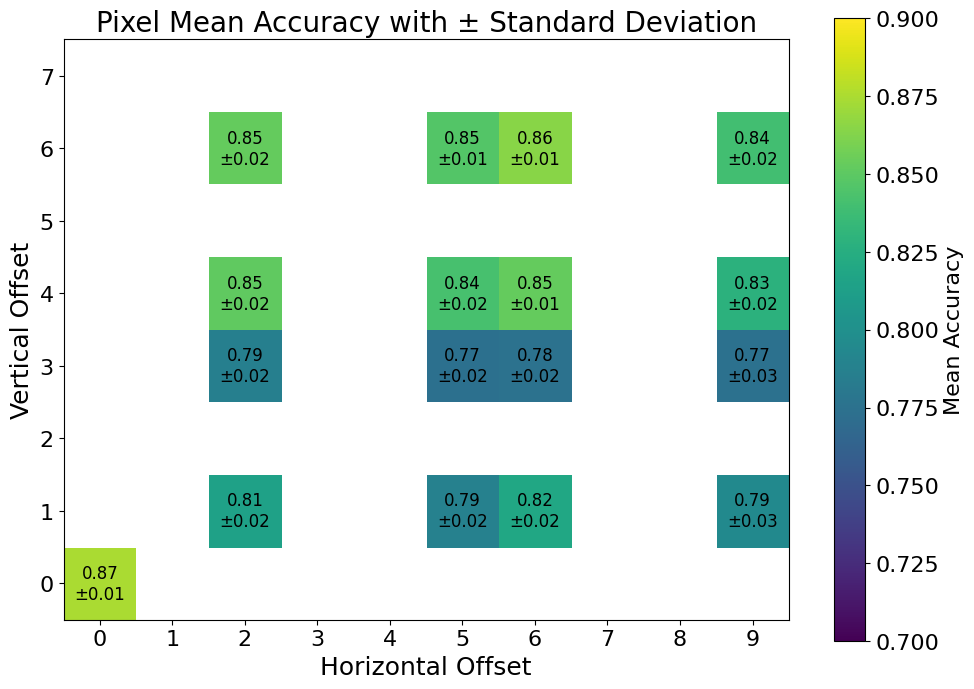

In [14]:
h_r = 8
v_r = 10
image_mean_acc = np.zeros((h_r,v_r), dtype=float)
image_std_acc = np.zeros((h_r,v_r), dtype=float)
image_count = np.zeros((h_r,v_r), dtype=int)
image_std_acc[:,:] = np.nan

test_acc = combined_df_bw_grouped_series['test_acc'].agg(['mean', 'std', 'count']).reset_index()

for index, row in test_acc.iterrows():
    h_r_offset, v_r_offset = row['h_r_offset_v_r_offset_zipped']
    image_mean_acc[h_r_offset, v_r_offset] = row['mean']
    image_std_acc[h_r_offset, v_r_offset] = row['std']
    image_count[h_r_offset, v_r_offset] = row['count']

plt.figure(figsize=(10, 7))

# Display the mean values as the color of the pixels
cmap = plt.cm.viridis
cmap.set_under(color='white')  # Set color for pixels with no data

plt.imshow(image_mean_acc, cmap=cmap, vmin=0.7, vmax=0.90)  # Adjust vmin and vmax as needed
cbar = plt.colorbar()
cbar.set_label('Mean Accuracy', fontsize=16)  # Adjust size as needed
cbar.ax.tick_params(labelsize=16)  # Adjust the tick label size

# Annotate the pixels with mean ± std, or '-' for no data
for i in range(h_r):
    for j in range(v_r):
        if (image_std_acc[i, j] > 0):
            text = f'{image_mean_acc[i, j]:.2f}\n±{image_std_acc[i, j]:.2f}' #+ f'\n#={image_count[i, j]}'
        else:
            text = ''
        plt.text(j, i, text, ha='center', va='center', color='black', fontsize=12)

# Set the title and show the plot
plt.title('Pixel Mean Accuracy with ± Standard Deviation', fontsize=20)
plt.xlabel('Horizontal Offset', fontsize=18)
plt.ylabel('Vertical Offset', fontsize=18)
plt.xticks(range(v_r), fontsize=16)
plt.yticks(range(h_r), fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.grid(False)
plt.tight_layout()
plt.savefig(os.path.join(subfolder_name,f'pixel_mean_accuracy_{ds_name}.eps'))
plt.show()